# **Chicago Car Crash Analysis**

![Title](https://images.fineartamerica.com/images-medium-large-5/chicago-traffic-and-skyline-at-dusk-chrisp0.jpg)


# **Overview**

The City of Chicago's Department of Transportation is embarking on an initiative to enhance road safety by identifying patterns in car crashes. The primary objective of this project is to develop a predictive model that accurately identifies the contributory causes of car accidents and highlights their key feature importances. By discerning these patterns, the city aims to generate three actionable recommendations to effectively address and mitigate the identified predictors, ultimately reducing the frequency of car crashes. This data-driven approach will enable the city to implement targeted measures that address specific risk factors, contributing to a safer and more secure transportation environment in Chicago.

* We are attempting to find patterns in order to create a safer Chicago. The goal of our analysis is to find the best model in predicting the primary contributory causes of car accidents and their main Feature Importances. From the top Feature Importances, we brainstorm a solution to mitigate those predictors and hence decrease number of crashes.


# **Business Problem**

In the year of 2023 alone, The City of Chicago witnessed more than 95,000 car crashes and counting. Among those incidents, 15,000 crashes resulted in injuries and, tragically fatalities. The city deserves a safer environment, and our goal is to identify the top features that significantly contribute to predicting the primary contributory cause of these incidents. Our goal is to enhance safety by identifying and addressing these critical features, ultimately aiming to reduce the number of crashes based on our top predictors.

* We want to find strategies and recommendations to decrease these numbers because the City of Chicago deserves better. We need to devise a strategy to make this city safer. In order to do this, we need to find the top features that play a major role in predicting our target, which is the primary contributory cause. Using those features, we will provide our recommendations in order decrease number of crashes based on our top predictors.

# **Data Understanding**

The data comes from the Chicago Data Portal of the City of Chicago Transportation website. We were presented with 3 datasets:

- Traffic Crashes - Crashes
This dataset contains of information about each traffic crash in city streets within the city of Chicago.
- Traffic Crashes - Vehicles
This dataset contains of information about the vehicles involved in a traffic crash.
- Traffic Crashes - People
This dataset contains information about people involved in a traffic crash and if any injuries were sustained.


We created a master dataset by combining all three datasets by a common ID column, "CRASH_RECORD_ID". However, due to the size of the master dataset, the dataset used in this notebook has been filtered. 

First, we dropped most of the columns in the master dataset and ended up with a total of 35 columns with 31 variables. Second, we filtered the data further to include only the years between 2020 to 2023, having total injuries more than 0, and vehicle types to only include Passenger, Sport Utility Vehicles (SUVs), and Van/Mini-van.

In [576]:
# Importing necessary packages needed for this notebook
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, auc, accuracy_score, mean_squared_error, f1_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

In [577]:
master_df = pd.read_csv('data/master_df.csv')

## Looking at our data

In [578]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305598 entries, 0 to 305597
Data columns (total 35 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_RECORD_ID          305598 non-null  object 
 1   CRASH_DATE               305598 non-null  object 
 2   POSTED_SPEED_LIMIT       305598 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE   305598 non-null  object 
 4   DEVICE_CONDITION         305598 non-null  object 
 5   WEATHER_CONDITION        305598 non-null  object 
 6   LIGHTING_CONDITION       305598 non-null  object 
 7   FIRST_CRASH_TYPE         305598 non-null  object 
 8   TRAFFICWAY_TYPE          305598 non-null  object 
 9   ALIGNMENT                305598 non-null  object 
 10  ROADWAY_SURFACE_COND     305598 non-null  object 
 11  ROAD_DEFECT              305598 non-null  object 
 12  CRASH_TYPE               305598 non-null  object 
 13  DAMAGE                   305598 non-null  object 
 14  PRIM

# **Feature Engineering**

### Going over our Target Column

In [579]:
master_df["PRIM_CONTRIBUTORY_CAUSE"].value_counts()

PRIM_CONTRIBUTORY_CAUSE
UNABLE TO DETERMINE                                                                 83621
FAILING TO YIELD RIGHT-OF-WAY                                                       53085
FOLLOWING TOO CLOSELY                                                               26314
FAILING TO REDUCE SPEED TO AVOID CRASH                                              26078
DISREGARDING TRAFFIC SIGNALS                                                        24689
IMPROPER TURNING/NO SIGNAL                                                          11340
IMPROPER OVERTAKING/PASSING                                                          9315
NOT APPLICABLE                                                                       9116
DISREGARDING STOP SIGN                                                               8654
OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER     7296
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                         

- After looking at our Target Column, "Primary Contributory Cause", we decided to narrow the classification groups down to 5 factors.

In [580]:
# Narrowing our target column to 5 classification groups
prim_cause_dict = { 'FOLLOWING TOO CLOSELY': "HUMAN FACTORS", 'FAILING TO REDUCE SPEED TO AVOID CRASH': "HUMAN FACTORS", 
                   'IMPROPER TURNING/NO SIGNAL': 'HUMAN FACTORS', 'IMPROPER OVERTAKING/PASSING' : 'HUMAN FACTORS',
                   'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER': 'HUMAN FACTORS',
                   'PHYSICAL CONDITION OF DRIVER': "HUMAN FACTORS", 
                   'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)': "HUMAN FACTORS",
                   'DISTRACTION - FROM INSIDE VEHICLE':"HUMAN FACTORS", 'DISTRACTION - FROM OUTSIDE VEHICLE': 'HUMAN FACTORS',
                   'TEXTING':"HUMAN FACTORS", 'IMPROPER BACKING':"HUMAN FACTORS", 'CELL PHONE USE OTHER THAN TEXTING': "HUMAN FACTORS",
                   'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)': "HUMAN FACTORS", 
                   'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)':"HUMAN FACTORS",
                   'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)': "ENVIRONMENTAL FACTORS", 'ANIMAL': "ENVIRONMENTAL FACTORS",
                   'WEATHER': "ENVIRONMENTAL FACTORS", 'EVASIVE ACTION DUE TO ANIMAL,OBJECT, NONMOTORIST': "ENVIRONMENTAL FACTORS",
                   'FAILING TO YIELD RIGHT-OF-WAY':"SIGNAGE/TRAFFIC CONTROL DEVICES", 'DISREGARDING TRAFFIC SIGNALS': "SIGNAGE/TRAFFIC CONTROL DEVICES",
                   'DISREGARDING STOP SIGN':"SIGNAGE/TRAFFIC CONTROL DEVICES", 'DRIVING ON WRONG SIDE/WRONG WAY':"SIGNAGE/TRAFFIC CONTROL DEVICES",
                   'IMPROPER LANE USAGE': "SIGNAGE/TRAFFIC CONTROL DEVICES", 'DISREGARDING OTHER TRAFFIC SIGNS':"SIGNAGE/TRAFFIC CONTROL DEVICES",
                   'TURNING RIGHT ON RED': "SIGNAGE/TRAFFIC CONTROL DEVICES", 'DISREGARDING ROAD MARKINGS':"SIGNAGE/TRAFFIC CONTROL DEVICES",
                   'DISREGARDING YIELD SIGN': "SIGNAGE/TRAFFIC CONTROL DEVICES", 'RELATED TO BUS STOP': "SIGNAGE/TRAFFIC CONTROL DEVICES",
                   'PASSING STOPPED SCHOOL BUS': "SIGNAGE/TRAFFIC CONTROL DEVICES", 
                   'ROAD CONSTRUCTION/MAINTENANCE': "INFRASTRUCTURE ISSUES", 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS': "INFRASTRUCTURE ISSUES",
                   'OBSTRUCTED CROSSWALKS': "INFRASTRUCTURE ISSUES", 
                   'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': "MISC FACTORS", 'BICYCLE ADVANCING LEGALLY ON RED LIGHT':"MISC FACTORS",
                   'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT':"MISC FACTORS", 'EQUIPMENT - VEHICLE CONDITION': "MISC FACTORS",
                   'NOT APPLICABLE': "MISC FACTORS"
              }

master_df['PRIM_CONTRIBUTORY_CAUSE'] = master_df['PRIM_CONTRIBUTORY_CAUSE'].map(prim_cause_dict)
master_df['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

PRIM_CONTRIBUTORY_CAUSE
SIGNAGE/TRAFFIC CONTROL DEVICES    100090
HUMAN FACTORS                       95907
MISC FACTORS                        18567
ENVIRONMENTAL FACTORS                6333
INFRASTRUCTURE ISSUES                 492
Name: count, dtype: int64

- Next, we look at the possible variables and do some Feature Engineering if possible.

In [581]:
# Road Defect
defect_dict = {"NO DEFECTS" : "NO DEFECTS", "UNKNOWN": "NO DEFECTS", "WORN SURFACE": "DEFECTS", "OTHER":"DEFECTS","RUT, HOLES": "DEFECTS", "SHOULDER DEFECT":"DEFECTS", "DEBRIS ON ROADWAY": "DEFECTS"}

master_df['ROAD_DEFECT'] = master_df['ROAD_DEFECT'].map(defect_dict)

In [582]:
# Damage
master_df['DAMAGE'] = master_df['DAMAGE'].apply(lambda x: 'OVER $1500' if 'OVER $1,500' in x else "UNDER $1500")

In [583]:
# Changes to No Injury, Minor, Major, and Fatality
injury_dict = {'NONINCAPACITATING INJURY': 'MINOR INJURIES',
              'REPORTED, NOT EVIDENT': 'MINOR INJURIES', 'INCAPACITATING INJURY' : 'MAJOR INJURIES',
              'FATAL': 'FATAL'}

master_df['SEVERE_INJURY'] = master_df['MOST_SEVERE_INJURY'].map(injury_dict)
master_df.drop(labels="MOST_SEVERE_INJURY", axis=1, inplace=True)
master_df['SEVERE_INJURY'].value_counts()

SEVERE_INJURY
MINOR INJURIES    267484
MAJOR INJURIES     35384
FATAL               2730
Name: count, dtype: int64

In [584]:
# Dropping LIC_PLATE_STATE column
master_df.drop(labels="LIC_PLATE_STATE", axis=1, inplace=True)

In [585]:
# Traffic Control Device
master_df['TRAFFIC_CONTROL_DEVICE'] = master_df['TRAFFIC_CONTROL_DEVICE'].apply(lambda x: 'SIGNAL' if 'SIGNAL' in x else x)
master_df['TRAFFIC_CONTROL_DEVICE'] = master_df['TRAFFIC_CONTROL_DEVICE'].apply(lambda x: 'SIGN' if ' SIGN' in x else x)

traffic_dict = {'NO CONTROLS': 'NO CONTROLS', 'SIGNAL':'SIGNAL', 'SIGN': 'SIGN', 'UNKNOWN': 'OTHER',
               'OTHER': 'OTHER', 'LANE USE MARKING': 'SIGN', 'YIELD':'SIGN', 'RAILROAD CROSSING GATE': 'SIGNAL',
               'SCHOOL ZONE': 'SIGN', 'DELINEATORS': 'OTHER', 'POLICE/FLAGMAN': 'OTHER', 
               'OTHER RAILROAD CROSSING': 'SIGNAL', 'NO PASSING': 'SIGN', }
master_df['TRAFFIC_CONTROL_DEVICE'] = master_df['TRAFFIC_CONTROL_DEVICE'].map(traffic_dict)

In [586]:
# Device Condition
device_dict = {'NO CONTROLS': 'NO CONTROLS',
               'FUNCTIONING PROPERLY': 'FUNCTIONING PROPERLY',
               'UNKNOWN': 'NO CONTROLS',
               'FUNCTIONING IMPROPERLY':'FUNCTIONING IMPROPERLY/ MISSING',
               'NOT FUNCTIONING':'FUNCTIONING IMPROPERLY/ MISSING',
               'WORN REFLECTIVE MATERIAL': 'FUNCTIONING PROPERLY',
               'MISSING': 'FUNCTIONING IMPROPERLY/ MISSING',
               'OTHER': 'FUNCTIONING PROPERLY'}
master_df['DEVICE_CONDITION'] = master_df['DEVICE_CONDITION'].map(device_dict)
master_df['DEVICE_CONDITION'].value_counts()

DEVICE_CONDITION
FUNCTIONING PROPERLY               166129
NO CONTROLS                        136300
FUNCTIONING IMPROPERLY/ MISSING      3169
Name: count, dtype: int64

In [587]:
# Weather Condition
weather_dict = {'CLEAR': 'CLEAR', 'RAIN': 'INCLEMENT', 'CLOUDY/OVERCAST': 'INCLEMENT', 'SNOW': 'INCLEMENT', 'UNKNOWN': 'CLEAR', 'OTHER': 'CLEAR',
                'FREEZING RAIN/DRIZZLE': 'INCLEMENT', 'BLOWING SNOW':'INCLEMENT', 'FOG/SMOKE/HAZE': 'INCLEMENT', 'SLEET/HAIL': 'INCLEMENT', 'SEVERE CROSS WIND GATE': 'INCLEMENT',
                'BLOWING SAND, SOIL, DIRT': 'INCLEMENT'
               }
master_df['WEATHER_CONDITION'] = master_df['WEATHER_CONDITION'].map(weather_dict)
master_df['WEATHER_CONDITION'].value_counts()

WEATHER_CONDITION
CLEAR        255871
INCLEMENT     49727
Name: count, dtype: int64

In [588]:
# Lighting Condition
lighting_dict = {'DAYLIGHT':'VISIBLE','DARKNESS, LIGHTED ROAD':'DIMINISHED VISIBILITY', 'DARKNESS':'DIMINISHED VISIBILITY',
                'DUSK':'DIMINISHED VISIBILITY', 'DAWN': 'DIMINISHED VISIBILITY', 'UNKNOWN': 'VISIBLE'}
master_df['LIGHTING_CONDITION'] = master_df['LIGHTING_CONDITION'].map(lighting_dict)
master_df['LIGHTING_CONDITION'].value_counts()

LIGHTING_CONDITION
VISIBLE                  190051
DIMINISHED VISIBILITY    115547
Name: count, dtype: int64

In [589]:
# First Crash Type
first_crash_dict = {'REAR END': 'REAR END', 'SIDESWIPE SAME DIRECTION': 'SIDE SWIPE', 'TURNING': 'TURNING', 'PARKED MOTOR VEHICLE': 'OBJECT', 'ANGLE': 'ANGLE', 'PEDESTRIAN': 'PERSON OR ANIMAL',
                    'SIDESWIPE OPPOSITE DIRECTION': 'SIDE SWIPE', 'FIXED OBJECT': 'OBJECT', 'PEDALCYCLIST': 'PERSON OR ANIMAL', 'HEAD ON': 'OTHER', 'REAR TO FRONT': 'OTHER',
                    'REAR TO SIDE': 'OTHER', 'OTHER OBJECT': 'OBJECT', 'REAR TO REAR': 'OTHER', 'OTHER NONCOLLISION': 'OTHER', 'ANIMAL': 'PERSON OR ANIMAL', 'OVERTURNED': 'OTHER', 'TRAIN': 'OTHER'
                    }
master_df['FIRST_CRASH_TYPE'] = master_df['FIRST_CRASH_TYPE'].map(first_crash_dict)
master_df['FIRST_CRASH_TYPE'].value_counts()

FIRST_CRASH_TYPE
REAR END            79129
ANGLE               74256
TURNING             64269
SIDE SWIPE          27307
OBJECT              24914
PERSON OR ANIMAL    23337
OTHER               12386
Name: count, dtype: int64

In [590]:
# Traffic Way Type
trafficway_dict = {'NOT DIVIDED': 'NOT DIVIDED', 'DIVIDED - W/MEDIAN (NOT RAISED)': 'DIVIDED', 'ONE-WAY': 'OTHER', 'FOUR WAY': 'OTHER', 'DIVIDED - W/MEDIAN BARRIER': 'DIVIDED',
                    'PARKING LOT': 'OTHER', 'OTHER': 'OTHER', 'T-INTERSECTION': 'INTERSECTION', 'ALLEY': 'OTHER', 'UNKNOWN': 'NOT DIVIDED', 'CENTER TURN LANE': 'OTHER', 
                    'UNKNOWN INTERSECTION TYPE': 'INTERSECTION', 'RAMP': 'OTHER', 'DRIVEWAY': 'OTHER', 'FIVE POINT, OR MORE': 'OTHER', 'Y-INTERSECTION': 'INTERSECTION', 
                    'TRAFFIC ROUTE': 'OTHER', 'NOT REPORTED': 'OTHER', 'ROUNDABOUT': 'INTERSECTION', 'L-INTERSECTION': 'INTERSECTION'
               }
master_df['TRAFFICWAY_TYPE'] = master_df['TRAFFICWAY_TYPE'].map(trafficway_dict)
master_df['TRAFFICWAY_TYPE'].value_counts()

TRAFFICWAY_TYPE
NOT DIVIDED     117555
OTHER           102352
DIVIDED          70933
INTERSECTION     14758
Name: count, dtype: int64

In [591]:
# Alignment
alignment_dict = {'STRAIGHT AND LEVEL': 'STRAIGHT', 'STRAIGHT ON GRADE': 'STRAIGHT', 'CURVE, LEVEL': 'NOT STRAIGHT', 'STRAIGHT ON HILLCREST': 'STRAIGHT',
                    'CURVE ON GRADE': 'NOT STRAIGHT', 'CURVE ON HILLCREST': 'NOT STRAIGHT'
               }
master_df['ALIGNMENT'] = master_df['ALIGNMENT'].map(alignment_dict)
master_df['ALIGNMENT'].value_counts()

ALIGNMENT
STRAIGHT        302355
NOT STRAIGHT      3243
Name: count, dtype: int64

In [592]:
# Roadway Surface Condition
roadway_surface_dict = {'DRY': 'DRY', 'WET': 'NOT DRY', 'UNKNOWN': 'DRY', 'SNOW OR SLUSH': 'NOT DRY', 'ICE': 'NOT DRY', 
                'OTHER': 'OTHER', 'SAND, MUD, DIRT': 'NOT DRY'
               }
master_df['ROADWAY_SURFACE_COND'] = master_df['ROADWAY_SURFACE_COND'].map(roadway_surface_dict)
master_df['ROADWAY_SURFACE_COND'].value_counts()

ROADWAY_SURFACE_COND
DRY        249355
NOT DRY     55410
OTHER         833
Name: count, dtype: int64

In [593]:
# Maneuver
MANEUVER_dict = {'STRAIGHT AHEAD': 'STRAIGHT', 'TURNING LEFT': 'OTHER', 'SLOW/STOP IN TRAFFIC': 'OTHER', 'PARKED': 'OTHER', 'TURNING RIGHT': 'OTHER', 'UNKNOWN/NA': 'STRAIGHT',
                 'OTHER': 'OTHER', 'PASSING/OVERTAKING': 'OTHER', 'CHANGING LANES': 'OTHER', 'U-TURN': 'OTHER', 'BACKING': 'OTHER', 'STARTING IN TRAFFIC': 'OTHER', 
                 'AVOIDING VEHICLES/OBJECTS': 'OTHER', 'ENTERING TRAFFIC LANE FROM PARKING': 'OTHER', 'SKIDDING/CONTROL LOSS': 'OTHER', 'DRIVING WRONG WAY': 'OTHER',
                 'MERGING': 'OTHER', 'ENTER FROM DRIVE/ALLEY': 'OTHER', 'PARKED IN TRAFFIC LANE': 'OTHER', 'NEGOTIATING A CURVE': 'OTHER', 'LEAVING TRAFFIC LANE TO PARK': 'OTHER',
                 'TURNING ON RED': 'OTHER', 'DISABLED': 'OTHER', 'DRIVERLESS': 'OTHER', 'DIVERGING': 'OTHER'}

master_df['MANEUVER'] = master_df['MANEUVER'].map(MANEUVER_dict)

In [594]:
# First Contact Point
master_df['FIRST_CONTACT_POINT'] = master_df['FIRST_CONTACT_POINT'].fillna('FRONT')

FIRST_CONTACT_POINT_dict = {'FRONT': 'FRONT', 'REAR': 'REAR', 'FRONT-LEFT-CORNER': 'FRONT', 'FRONT-RIGHT-CORNER': 'FRONT', 'SIDE-LEFT': 'SIDES', 'SIDE-RIGHT': 'SIDES', 
                            'REAR-LEFT-CORNER': 'REAR',
                            'REAR-RIGHT-CORNER':'REAR', 'SIDE-LEFT-REAR': 'SIDES', 'SIDE-LEFT-FRONT':'SIDES', 'SIDE-RIGHT-REAR':'SIDES', 'SIDE-RIGHT-FRONT': 'SIDES',
                            'TOTAL (ALL AREAS)': 'OTHER', 'NONE': 'NONE', 'OTHER': 'OTHER', 'UNDER CARRIAGE': 'OTHER', 'TOP': 'OTHER', 'ROOF': 'OTHER', 'UNKNOWN': 'FRONT',
                            'REAR-LEFT': 'REAR', 'FRONT-RIGHT': 'FRONT'}

master_df['FIRST_CONTACT_POINT'] = master_df['FIRST_CONTACT_POINT'].map(FIRST_CONTACT_POINT_dict)

In [595]:
# Person Type
PERSON_TYPE_dict = {'DRIVER': 'DRIVER', 'PASSENGER': 'PASSENGER', 'PEDESTRIAN': 'OTHER', 'BICYCLE': 'OTHER', 'NON-MOTOR VEHICLE': 'OTHER', 'NON-CONTACT VEHICLE': 'OTHER'}

master_df['PERSON_TYPE'] = master_df['PERSON_TYPE'].map(PERSON_TYPE_dict)

In [596]:
# Sex
master_df = master_df[master_df['SEX'] != 'X']

master_df['SEX'].value_counts(dropna=False)

SEX
M      157656
F      129998
NaN      7393
Name: count, dtype: int64

In [597]:
# Safety Equipment
master_df['SAFETY_EQUIPMENT'] = master_df['SAFETY_EQUIPMENT'].fillna('USAGE UNKNOWN')

SAFETY_EQUIPMENT_dict = {'USAGE UNKNOWN': 'UNKNOWN', 'SAFETY BELT USED': 'USED', 'NONE PRESENT': 'NONE', 'HELMET NOT USED': 'NOT USED', 'SAFETY BELT NOT USED': 'NOT USED',
                         'CHILD RESTRAINT - FORWARD FACING': 'USED', 'BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)': 'USED', 'CHILD RESTRAINT - TYPE UNKNOWN': 'USED',
                         'CHILD RESTRAINT - REAR FACING': 'USED', 'DOT COMPLIANT MOTORCYCLE HELMET': 'USED', 'BOOSTER SEAT': 'USED', 'CHILD RESTRAINT NOT USED': 'NOT USED', 
                         'CHILD RESTRAINT USED IMPROPERLY': 'USED', 'NOT DOT COMPLIANT MOTORCYCLE HELMET': 'USED', 'WHEELCHAIR': 'USED', 'SHOULD/LAP BELT USED IMPROPERLY': 'USED',
                         'HELMET USED': 'USED', 'STRETCHER': 'USED', 'CHILD RESTRAINT USED': 'USED'}

master_df['SAFETY_EQUIPMENT'] = master_df['SAFETY_EQUIPMENT'].map(SAFETY_EQUIPMENT_dict)

In [598]:
# Airbag Deployed
master_df['AIRBAG_DEPLOYED'] = master_df['AIRBAG_DEPLOYED'].fillna('DID NOT DEPLOY')

AIRBAG_DEPLOYED_dict = {'DID NOT DEPLOY': 'DID NOT DEPLOY', 'NOT APPLICABLE': 'NOT APPLICABLE', 'DEPLOYED, COMBINATION': 'DEPLOYED', 'DEPLOYMENT UNKNOWN': 'UNKNOWN', 
                        'DEPLOYED, FRONT': 'DEPLOYED', 'DEPLOYED, SIDE': 'DEPLOYED', 'DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)': 'DEPLOYED'}

master_df['AIRBAG_DEPLOYED'] = master_df['AIRBAG_DEPLOYED'].map(AIRBAG_DEPLOYED_dict)

In [599]:
# Driver Action
master_df['DRIVER_ACTION'] = master_df['DRIVER_ACTION'].fillna('NONE')

DRIVER_ACTION_dict = {'NONE': 'NO ACTION TAKEN', 'UNKNOWN': 'NO ACTION TAKEN', 'FAILED TO YIELD': 'ACTIONS TAKEN', 'OTHER': 'ACTIONS TAKEN', 'DISREGARDED CONTROL DEVICES': 'ACTIONS TAKEN',
                      'FOLLOWED TOO CLOSELY': 'ACTIONS TAKEN', 'TOO FAST FOR CONDITIONS': 'ACTIONS TAKEN', 'IMPROPER TURN': 'ACTIONS TAKEN', 'IMPROPER LANE CHANGE': 'ACTIONS TAKEN',
                      'IMPROPER PASSING': 'ACTIONS TAKEN', 'WRONG WAY/SIDE': 'ACTIONS TAKEN', 'IMPROPER BACKING': 'ACTIONS TAKEN', 'OVERCORRECTED': 'ACTIONS TAKEN', 'EVADING POLICE VEHICLE': 'ACTIONS TAKEN',
                      'CELL PHONE USE OTHER THAN TEXTING': 'ACTIONS TAKEN', 'EMERGENCY VEHICLE ON CALL': 'ACTIONS TAKEN', 'IMPROPER PARKING': 'ACTIONS TAKEN', 'TEXTING': 'ACTIONS TAKEN',
                      'LICENSE RESTRICTIONS': 'ACTIONS TAKEN', 'STOPPED SCHOOL BUS': 'ACTIONS TAKEN'}

master_df['DRIVER_ACTION'] = master_df['DRIVER_ACTION'].map(DRIVER_ACTION_dict)

In [600]:
# Driver Vision
master_df['DRIVER_VISION'] = master_df['DRIVER_VISION'].fillna('NONE')

DRIVER_VISION_dict = { 'NONE':'UNKNOWN', 'NOT OBSCURED': 'NOT OBSCURED', 'UNKNOWN': 'UNKNOWN', 'OTHER': 'OBSCURED', 'MOVING VEHICLES': 'OBSCURED', 'PARKED VEHICLES': 'OBSCURED',
                      'WINDSHIELD (WATER/ICE)': 'OBSCURED', 'BLINDED - SUNLIGHT': 'OBSCURED', 'TREES, PLANTS': 'OBSCURED', 'BUILDINGS': 'OBSCURED',
                      'BLINDED - HEADLIGHTS': 'OBSCURED', 'BLOWING MATERIALS': 'OBSCURED', 'HILLCREST': 'OBSCURED',
                      'EMBANKMENT': 'OBSCURED', 'SIGNBOARD': 'OBSCURED'}

master_df['DRIVER_VISION'] = master_df['DRIVER_VISION'].map(DRIVER_VISION_dict)

In [601]:
# Physical Condition
master_df['PHYSICAL_CONDITION'] = master_df['PHYSICAL_CONDITION'].fillna('UNKNOWN')

PHYSICAL_CONDITION_dict = {'UNKNOWN': 'UNKNOWN', 'NORMAL': 'NORMAL', 'REMOVED BY EMS': 'NOT NORMAL', 'IMPAIRED - ALCOHOL': 'NOT NORMAL', 'OTHER': 'NOT NORMAL', 'EMOTIONAL': 'NOT NORMAL',
                           'FATIGUED/ASLEEP': 'NOT NORMAL', 'ILLNESS/FAINTED': 'NOT NORMAL', 'IMPAIRED - DRUGS': 'NOT NORMAL', 'HAD BEEN DRINKING': 'NOT NORMAL', 
                           'IMPAIRED - ALCOHOL AND DRUGS': 'NOT NORMAL', 'MEDICATED': 'NOT NORMAL'}

master_df['PHYSICAL_CONDITION'] = master_df['PHYSICAL_CONDITION'].map(PHYSICAL_CONDITION_dict)

In [602]:
# BAC Result
master_df['BAC_RESULT'] = master_df['BAC_RESULT'].fillna('UNKNOWN')

BAC_RESULT_dict = {'TEST NOT OFFERED': 'TEST NOT OFFERED', 'TEST REFUSED': 'TEST REFUSED', 'TEST PERFORMED, RESULTS UNKNOWN': 'TEST PERFORMED',
                   'TEST TAKEN': 'TEST PERFORMED'}

master_df['BAC_RESULT'] = master_df['BAC_RESULT'].map(BAC_RESULT_dict)

# Visualizations

- We are looking to find patterns or trends among the variables vs. Number of Crashes to determine possible Feature Importances to take into account.

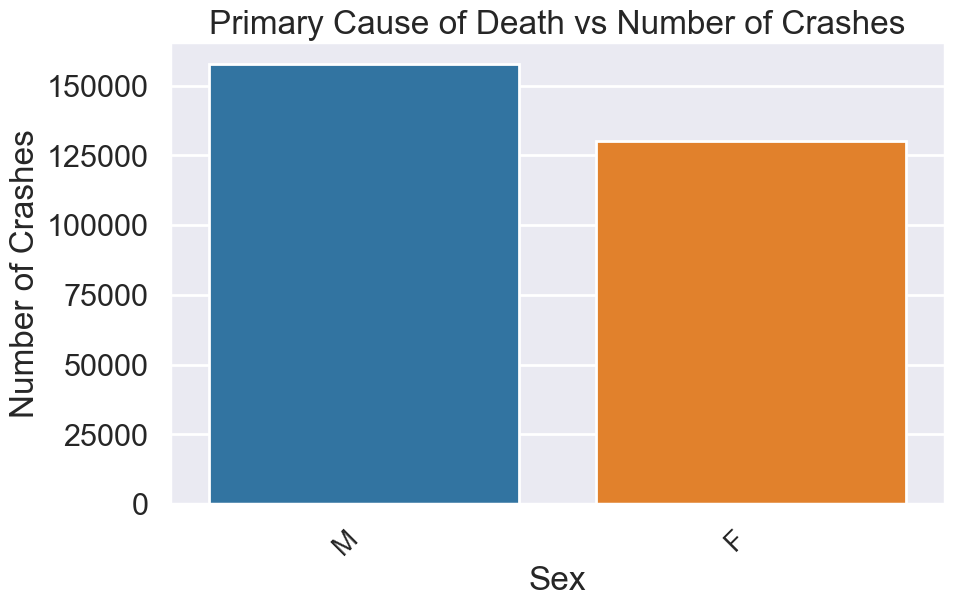

In [603]:
# Visualizing Sex vs. Number of Crashes

sns.set_context("poster")
sns.set_style("darkgrid")
plt.figure(figsize =(10,6))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='small'
)

ax = sns.countplot(x="SEX", data=master_df,order = master_df['SEX'].value_counts().head(30).index)
plt.xlabel('Sex')
plt.ylabel('Number of Crashes')
plt.title('Primary Cause of Death vs Number of Crashes')
plt.show();

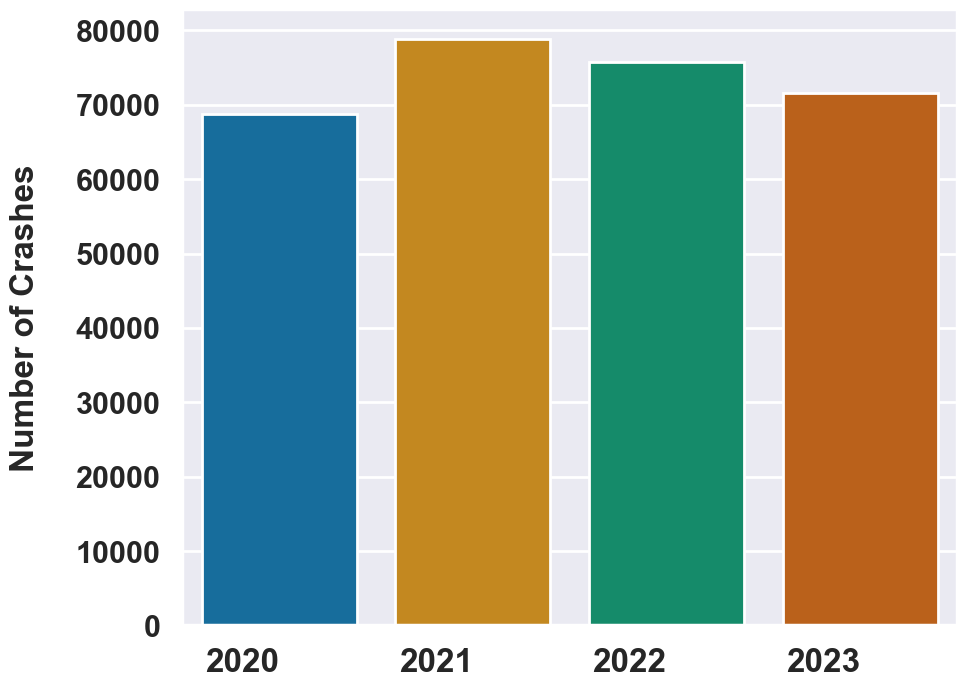

In [604]:
# Visualizing Year (2020-2023) vs. Number of Crashes

year_counts = master_df['YEAR'].value_counts()

colors = sns.color_palette("colorblind", len(year_counts))

plt.figure(figsize=(10, 8))
ax = sns.barplot(x=year_counts.index, y=year_counts.values, palette=colors)

plt.xticks(ha='right', fontsize='medium', fontweight='bold')
plt.yticks(fontweight='bold')
plt.ylabel('Number of Crashes', fontweight='bold', fontsize='medium', labelpad=25)
plt.xlabel(None)
plt.show();

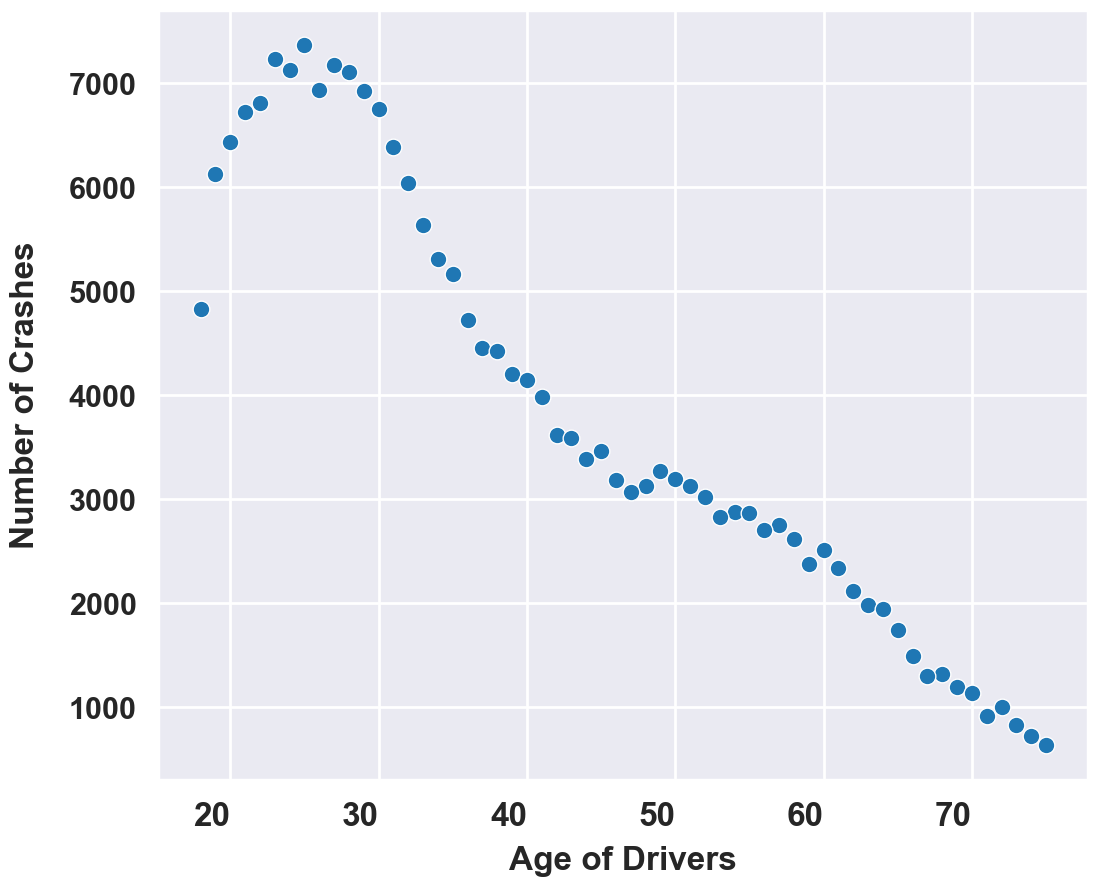

In [605]:
# Visualizing Age (18-75) vs. Number of Crashes

sns.set_context("poster")
sns.set_style("darkgrid")

# Filter data between ages 18 and 75
filtered_master_df = master_df[(master_df['AGE'] >= 18) & (master_df['AGE'] <= 75)]

plt.figure(figsize=(12, 10))

age_counts = filtered_master_df['AGE'].value_counts()

ax = sns.scatterplot(x=age_counts.index, y=age_counts.values)

plt.xticks(horizontalalignment='right', fontsize= 'medium', fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Age of Drivers', fontweight='bold', fontsize='medium', labelpad=10)
plt.ylabel('Number of Crashes', fontweight='bold', fontsize= 'medium', labelpad=20)
plt.show();

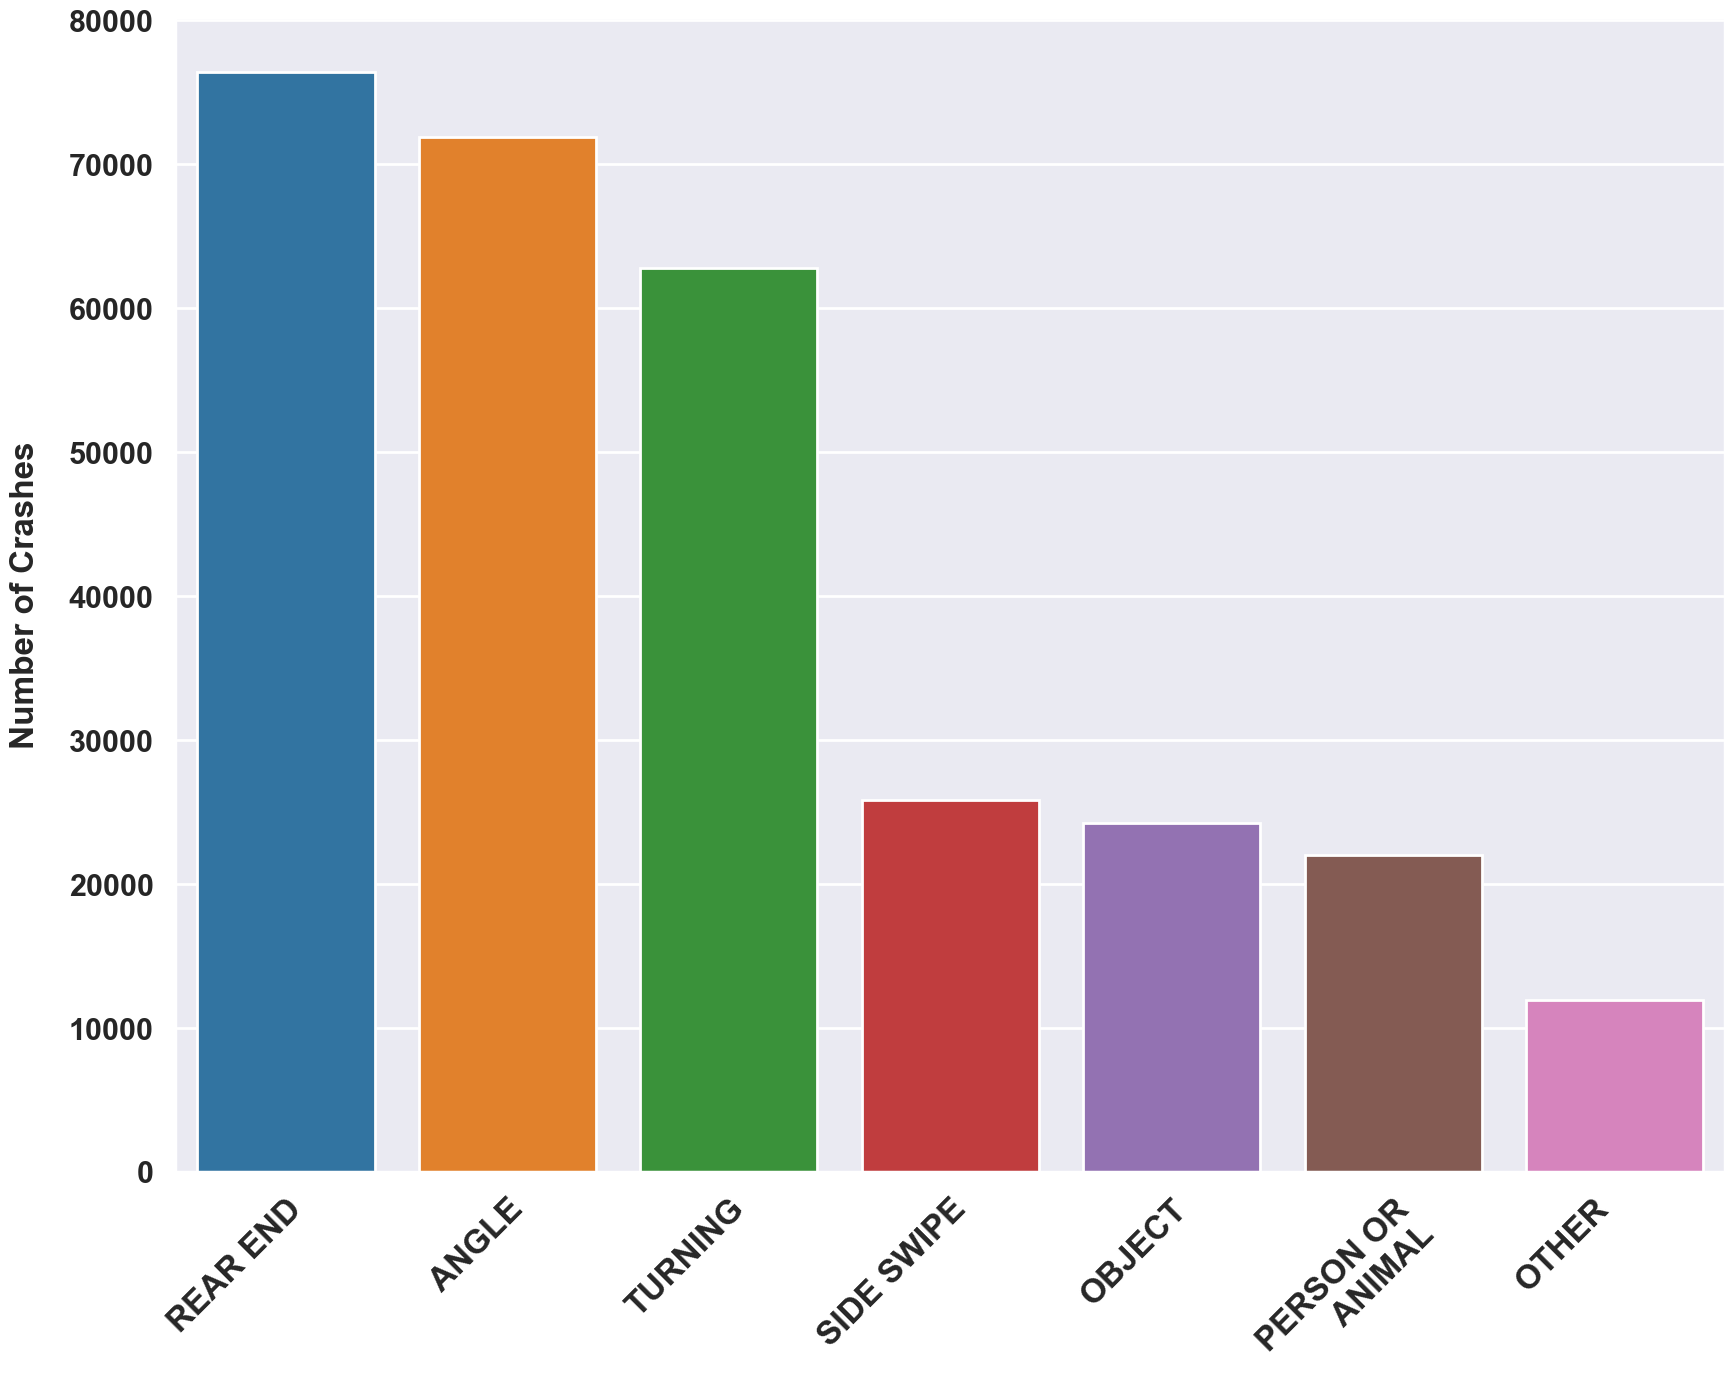

In [606]:
# Visualizing Crash Type vs. Number of Crashes

sns.set_context("poster")
sns.set_style("darkgrid")
plt.figure(figsize =(20,15))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='medium',
    fontweight='bold',
    wrap=True,
)
plt.yticks(fontweight='bold')

ax = sns.countplot(x="FIRST_CRASH_TYPE", data=master_df, order=master_df['FIRST_CRASH_TYPE'].value_counts().index)

plt.ylabel('Number of Crashes', fontweight='bold', labelpad=20, fontsize='medium')
plt.xlabel(None)
plt.show();

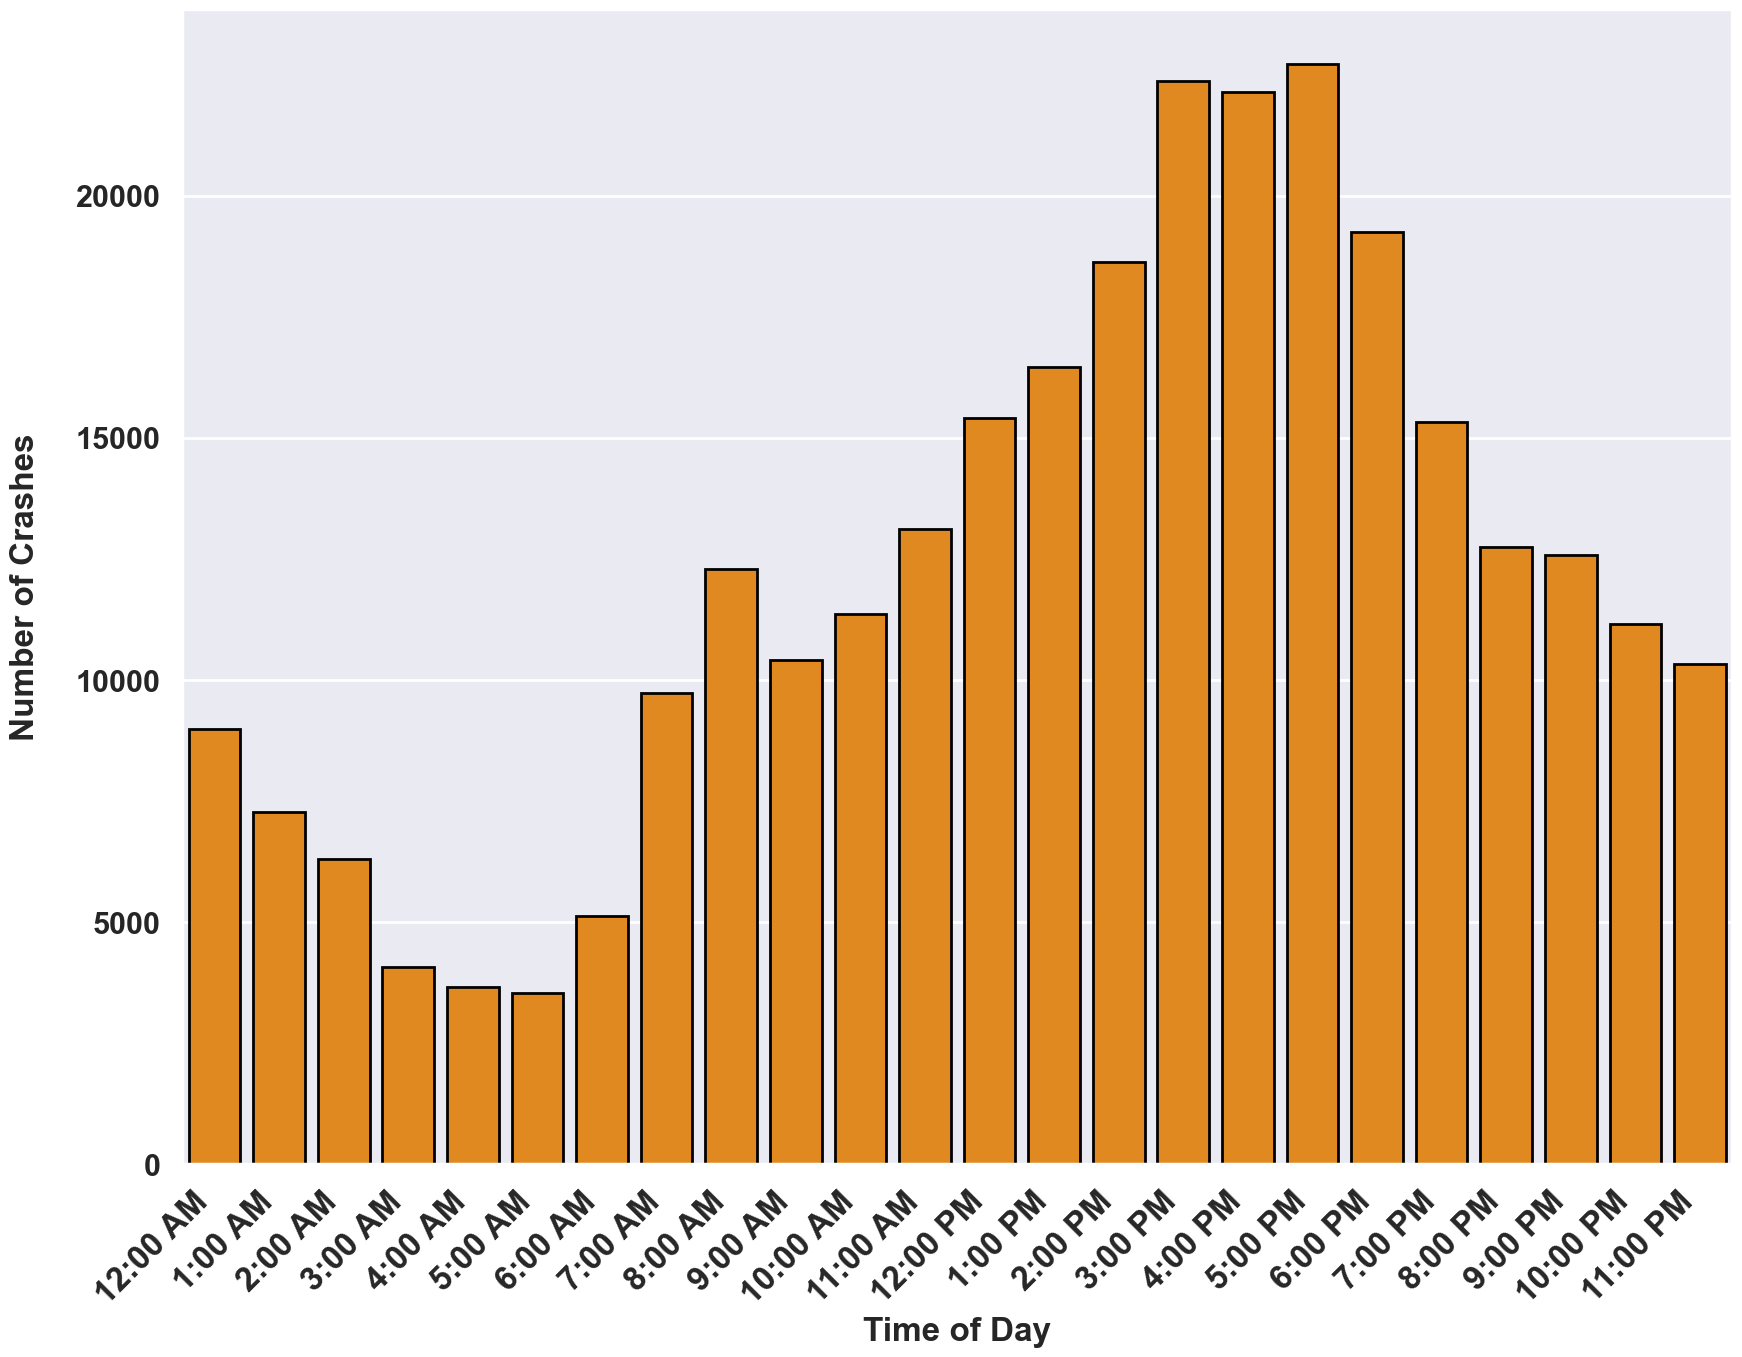

In [607]:
# Visualizing Time of Day vs. Number of Crashes

sns.set_context("poster")
sns.set_style("darkgrid")


plt.figure(figsize =(20,15))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='medium',
    fontweight='bold'
)
plt.yticks(fontweight='bold')
custom_labels=["12:00 AM","1:00 AM","2:00 AM","3:00 AM","4:00 AM","5:00 AM","6:00 AM","7:00 AM","8:00 AM","9:00 AM","10:00 AM","11:00 AM",
                "12:00 PM","1:00 PM","2:00 PM","3:00 PM","4:00 PM","5:00 PM","6:00 PM","7:00 PM","8:00 PM","9:00 PM","10:00 PM","11:00 PM"]

ax = sns.countplot(x="CRASH_HOUR", data=master_df, color='darkorange', edgecolor="black")
ax.set_xticklabels(custom_labels)
plt.xlabel('Time of Day',fontsize='medium', fontweight='bold')
plt.ylabel('Number of Crashes',fontsize='medium', fontweight='bold', labelpad=25)
plt.show();

# Preprocessing for Modeling

In [608]:
#View our cleaned columns
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295047 entries, 0 to 305597
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_RECORD_ID          295047 non-null  object 
 1   CRASH_DATE               295047 non-null  object 
 2   POSTED_SPEED_LIMIT       295047 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE   295047 non-null  object 
 4   DEVICE_CONDITION         295047 non-null  object 
 5   WEATHER_CONDITION        295047 non-null  object 
 6   LIGHTING_CONDITION       295047 non-null  object 
 7   FIRST_CRASH_TYPE         295047 non-null  object 
 8   TRAFFICWAY_TYPE          295047 non-null  object 
 9   ALIGNMENT                295047 non-null  object 
 10  ROADWAY_SURFACE_COND     295047 non-null  object 
 11  ROAD_DEFECT              295047 non-null  object 
 12  CRASH_TYPE               295047 non-null  object 
 13  DAMAGE                   295047 non-null  object 
 14  PRIM_CONT

In [609]:
#We can get rid of RECORD_ID and DATE, not relevant for ML
master_df.drop(labels=["CRASH_RECORD_ID","CRASH_DATE"], axis=1, inplace=True)

In [610]:
# PRIM_CONTRIBUTORY_CAUSE - drop missing values

master_df.dropna(subset=["PRIM_CONTRIBUTORY_CAUSE"],inplace=True)

# SEX - drop missing values
master_df.dropna(subset=["SEX"], inplace=True)

In [611]:
# Set our target
y = master_df["PRIM_CONTRIBUTORY_CAUSE"]
X = master_df.drop("PRIM_CONTRIBUTORY_CAUSE", axis=1)

In [612]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [613]:
# Check for any missing values left
X_train.isna().sum()

POSTED_SPEED_LIMIT            0
TRAFFIC_CONTROL_DEVICE        0
DEVICE_CONDITION              0
WEATHER_CONDITION             0
LIGHTING_CONDITION            0
FIRST_CRASH_TYPE              0
TRAFFICWAY_TYPE               0
ALIGNMENT                     0
ROADWAY_SURFACE_COND          0
ROAD_DEFECT                   0
CRASH_TYPE                    0
DAMAGE                        0
NUM_UNITS                     0
INJURIES_TOTAL                0
CRASH_HOUR                    0
CRASH_DAY_OF_WEEK             0
CRASH_MONTH                   0
VEHICLE_TYPE                  0
MANEUVER                      0
FIRST_CONTACT_POINT           0
PERSON_TYPE                   0
SEX                           0
AGE                       19395
SAFETY_EQUIPMENT              0
AIRBAG_DEPLOYED               0
DRIVER_ACTION                 0
DRIVER_VISION                 0
PHYSICAL_CONDITION            0
BAC_RESULT                48556
YEAR                          0
SEVERE_INJURY                 0
dtype: i

In [614]:
# Filling null values in AGE column with the mean
X_train["AGE"]=X_train['AGE'].fillna(X_train['AGE'].mean())
X_train['AGE'].value_counts()

AGE
35.425718     19395
25.000000      4082
23.000000      4073
27.000000      4009
24.000000      3970
              ...  
102.000000        4
96.000000         4
100.000000        3
98.000000         1
110.000000        1
Name: count, Length: 104, dtype: int64

In [615]:
# Filling null values in BAC_RESULT column with 
X_train['BAC_RESULT'].fillna(value="TEST NOT OFFERED",axis=0, inplace=True)
X_train['BAC_RESULT'].value_counts()

BAC_RESULT
TEST NOT OFFERED    153908
TEST REFUSED          1658
TEST PERFORMED        1319
Name: count, dtype: int64

In [616]:
# List of columns to be encoded:
category_list = ['TRAFFIC_CONTROL_DEVICE','DEVICE_CONDITION',"WEATHER_CONDITION","LIGHTING_CONDITION","FIRST_CRASH_TYPE","TRAFFICWAY_TYPE",
                 "ALIGNMENT","ROADWAY_SURFACE_COND","ROAD_DEFECT","CRASH_TYPE","DAMAGE","VEHICLE_TYPE","MANEUVER","FIRST_CONTACT_POINT","PERSON_TYPE","SEX",
                "SAFETY_EQUIPMENT","AIRBAG_DEPLOYED","DRIVER_ACTION","DRIVER_VISION","PHYSICAL_CONDITION","BAC_RESULT","SEVERE_INJURY"]

In [617]:
# OneHotEncoding all of our columns
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categories='auto')

encoded_train_arr = ohe.fit_transform(X_train[category_list]).toarray()
encoded_train_labels = ohe.get_feature_names_out()
encoded_train_labels
encoded_train_labels = np.array(encoded_train_labels).ravel()
encoded_train_arr = pd.DataFrame(encoded_train_arr, columns = encoded_train_labels, index=X_train.index)
encoded_train_arr

,TRAFFIC_CONTROL_DEVICE_NO CONTROLS,TRAFFIC_CONTROL_DEVICE_OTHER,TRAFFIC_CONTROL_DEVICE_SIGN,TRAFFIC_CONTROL_DEVICE_SIGNAL,DEVICE_CONDITION_FUNCTIONING IMPROPERLY/ MISSING,DEVICE_CONDITION_FUNCTIONING PROPERLY,DEVICE_CONDITION_NO CONTROLS,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_INCLEMENT,LIGHTING_CONDITION_DIMINISHED VISIBILITY,...,DRIVER_VISION_UNKNOWN,PHYSICAL_CONDITION_NORMAL,PHYSICAL_CONDITION_NOT NORMAL,PHYSICAL_CONDITION_UNKNOWN,BAC_RESULT_TEST NOT OFFERED,BAC_RESULT_TEST PERFORMED,BAC_RESULT_TEST REFUSED,SEVERE_INJURY_FATAL,SEVERE_INJURY_MAJOR INJURIES,SEVERE_INJURY_MINOR INJURIES
133967,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
146607,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
30651,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
247807,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
234029,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285209,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
98634,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
116684,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
84575,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [618]:
# Drop the original columns and append our encoded array
X_train.drop(category_list, axis=1, inplace=True)
X_train = pd.concat([X_train, encoded_train_arr], axis=1)

In [619]:
# Visually inspect X_train
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156885 entries, 133967 to 57728
Data columns (total 78 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   POSTED_SPEED_LIMIT                                156885 non-null  int64  
 1   NUM_UNITS                                         156885 non-null  int64  
 2   INJURIES_TOTAL                                    156885 non-null  float64
 3   CRASH_HOUR                                        156885 non-null  int64  
 4   CRASH_DAY_OF_WEEK                                 156885 non-null  int64  
 5   CRASH_MONTH                                       156885 non-null  int64  
 6   AGE                                               156885 non-null  float64
 7   YEAR                                              156885 non-null  int64  
 8   TRAFFIC_CONTROL_DEVICE_NO CONTROLS                156885 non-null  float64
 9   TRAFF

## Testing

In [620]:
# Do the same changes to X_test:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52296 entries, 238866 to 237489
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   POSTED_SPEED_LIMIT      52296 non-null  int64  
 1   TRAFFIC_CONTROL_DEVICE  52296 non-null  object 
 2   DEVICE_CONDITION        52296 non-null  object 
 3   WEATHER_CONDITION       52296 non-null  object 
 4   LIGHTING_CONDITION      52296 non-null  object 
 5   FIRST_CRASH_TYPE        52296 non-null  object 
 6   TRAFFICWAY_TYPE         52296 non-null  object 
 7   ALIGNMENT               52296 non-null  object 
 8   ROADWAY_SURFACE_COND    52296 non-null  object 
 9   ROAD_DEFECT             52296 non-null  object 
 10  CRASH_TYPE              52296 non-null  object 
 11  DAMAGE                  52296 non-null  object 
 12  NUM_UNITS               52296 non-null  int64  
 13  INJURIES_TOTAL          52296 non-null  float64
 14  CRASH_HOUR              52296 non-nul

In [621]:
# Deal with missing values
X_test.dropna(subset=["SEX"], inplace=True)
X_test["AGE"]=X_test['AGE'].fillna(X_test['AGE'].mean())
X_test['BAC_RESULT'].fillna(value="TEST NOT OFFERED",axis=0, inplace=True)

# Encode the categoricals
encoded_test_arr = ohe.fit_transform(X_test[category_list]).toarray()
encoded_test_labels = ohe.get_feature_names_out()
encoded_test_labels
encoded_test_labels = np.array(encoded_test_labels).ravel()
encoded_test_arr = pd.DataFrame(encoded_test_arr, columns = encoded_test_labels, index=X_test.index)
encoded_test_arr

# Drop orginal column and append our encoded columns
X_test.drop(category_list, axis=1, inplace=True)
X_test = pd.concat([X_test, encoded_test_arr], axis=1)

In [622]:
# Inspect X_test
X_test.info()
X_test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 52296 entries, 238866 to 237489
Data columns (total 78 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   POSTED_SPEED_LIMIT                                52296 non-null  int64  
 1   NUM_UNITS                                         52296 non-null  int64  
 2   INJURIES_TOTAL                                    52296 non-null  float64
 3   CRASH_HOUR                                        52296 non-null  int64  
 4   CRASH_DAY_OF_WEEK                                 52296 non-null  int64  
 5   CRASH_MONTH                                       52296 non-null  int64  
 6   AGE                                               52296 non-null  float64
 7   YEAR                                              52296 non-null  int64  
 8   TRAFFIC_CONTROL_DEVICE_NO CONTROLS                52296 non-null  float64
 9   TRAFFIC_CONTROL_

POSTED_SPEED_LIMIT              0
NUM_UNITS                       0
INJURIES_TOTAL                  0
CRASH_HOUR                      0
CRASH_DAY_OF_WEEK               0
                               ..
BAC_RESULT_TEST PERFORMED       0
BAC_RESULT_TEST REFUSED         0
SEVERE_INJURY_FATAL             0
SEVERE_INJURY_MAJOR INJURIES    0
SEVERE_INJURY_MINOR INJURIES    0
Length: 78, dtype: int64

# Modeling

We performed three different models in our endeavor to find the best model in predicting our target variable. Our baseline model is the Dummy Model.
We used Decision Tree Model for our second model because our data is a multiclass classification model.
Finally, we used Random Forest Model.
For each of our models, based on our business problem, we chose to use Accuracy score as our evaluation metric.

## Model 1: Dummy Classifier

In [623]:
dummy_model = DummyClassifier(strategy="most_frequent")

In [624]:
# Train the model on the training set
dummy_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dummy_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")

Accuracy: 0.4520995869664984


### Dummy Model with Different Strategy

In [625]:
dummy_classifier = DummyClassifier(strategy="uniform")

# Train the model on the training set
dummy_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dummy_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")

Accuracy: 0.20143031971852532


In [626]:
dummy_classifier = DummyClassifier(strategy="stratified")

# Train the model on the training set
dummy_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dummy_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")

Accuracy: 0.4001070827596757


### Dummy Model Summary

We picked this model because we needed to start somewhere. Disregarding input features, the Dummy Model is perfect for our baseline model. Regardless of the strategy we used for the Dummy Model, the highest Accuracy score we were able to attain was 45%.

## Model 2: Decision Tree Classifier

In [627]:
# Instantiating the Model
dt = DecisionTreeClassifier(max_depth=5, random_state=100)

dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=100)

- Based on our business problem, we determined that the appropriate max_depth value would be 5.

In [628]:
# Creating Target Prediction
y_pred_dt = dt.predict(X_test)
y_pred_dt

array(['SIGNAGE/TRAFFIC CONTROL DEVICES', 'HUMAN FACTORS',
       'SIGNAGE/TRAFFIC CONTROL DEVICES', ..., 'HUMAN FACTORS',
       'SIGNAGE/TRAFFIC CONTROL DEVICES', 'HUMAN FACTORS'], dtype=object)

#### Evaluation Metrics

In [629]:
# Accuracy Score
acc = accuracy_score(y_test, y_pred_dt) * 100
print("Accuracy: {0}".format(acc))

Accuracy: 70.08184182346642


In [630]:
# Recall Score
rec = recall_score (y_test, y_pred_dt, average='micro')
rec

0.7008184182346642

In [631]:
# Cross Validation
scores_dt = cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy')
scores_dt

array([0.7025847 , 0.69920643, 0.6984734 , 0.70366829, 0.69624247])

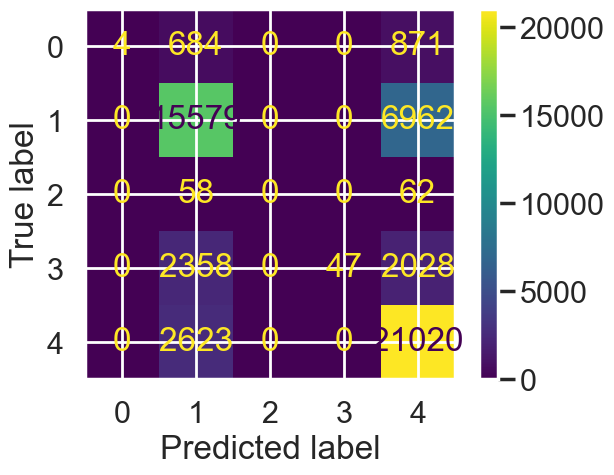

In [632]:
# Plotting Confusion Matrix
cm1 = confusion_matrix(y_test, y_pred_dt)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)

disp1.plot()
plt.show();

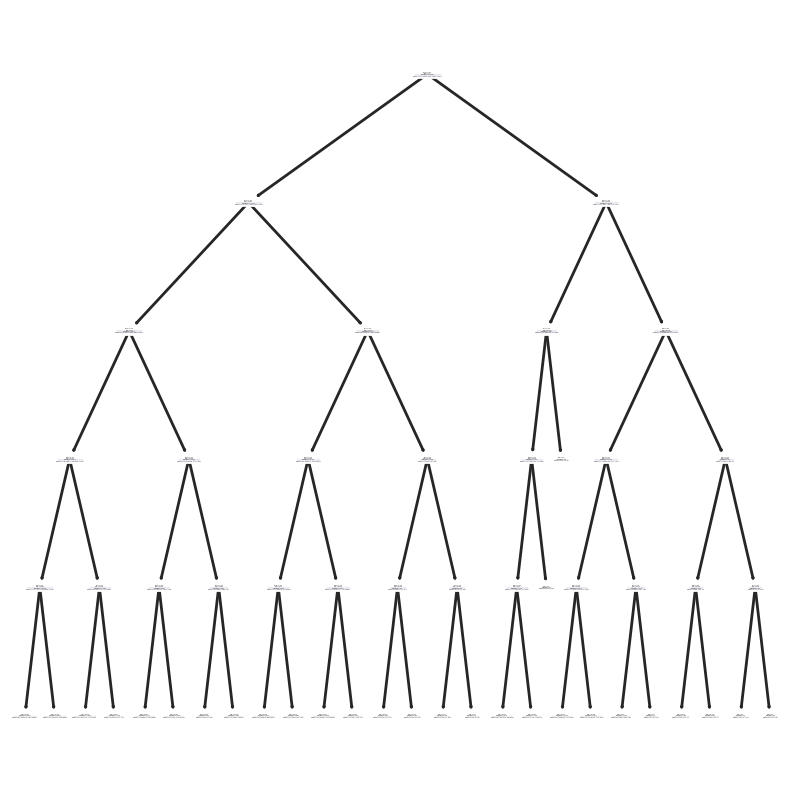

In [633]:
# Plotting Decision Tree Model
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(10, 10))

plot_tree(dt, ax=ax)

plt.show();

### Decision Tree Model Summary

The next model we tested was the Decision Tree Model. Since our target is a multiclass classification problem, we thought it was appropriate to use Decision Tree Model to see if it would predict our target better, considering our variables. Ultimately, the Decision Tree model performed better in predicting our target with an Accuracy score of about 70%.

## Model 3: Random Forest Classifer

In [634]:
# Instantiating the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=20, random_state=100)

- Based on our business problem, we determined that the n_estimators value appropriate would be 20.

In [635]:
# Fitting the Random Model
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=100)

In [636]:
# Creating Target Prediction
y_pred_rf = rf.predict(X_test)
y_pred_rf

array(['SIGNAGE/TRAFFIC CONTROL DEVICES', 'HUMAN FACTORS',
       'SIGNAGE/TRAFFIC CONTROL DEVICES', ...,
       'SIGNAGE/TRAFFIC CONTROL DEVICES',
       'SIGNAGE/TRAFFIC CONTROL DEVICES', 'HUMAN FACTORS'], dtype=object)

#### Evaluation Metrics

In [637]:
# Accuracy
accuracy_score_rf = accuracy_score(y_test, y_pred_rf)
accuracy_score_rf

0.8659935750344194

In [638]:
# Cross Validation
scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
scores_rf

array([0.8489658 , 0.84985818, 0.84909328, 0.84749976, 0.8438984 ])

### Feature Importances

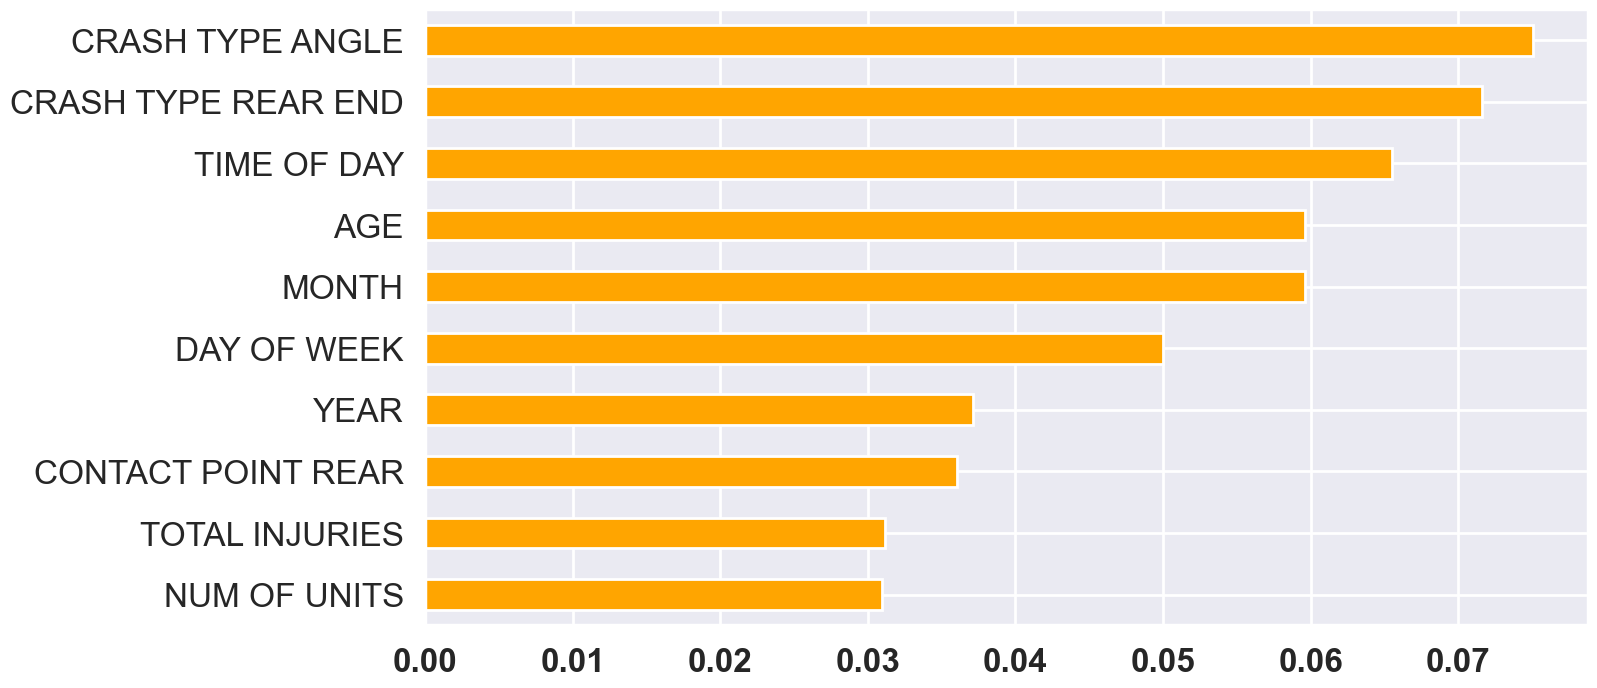

In [639]:
fig, ax = plt.subplots(figsize=(15, 8))

importances_rf = pd.Series(data = rf.feature_importances_,
                          index=X_train.columns)

importances_rf_sorted = importances_rf.sort_values()

top_10_importances = importances_rf_sorted.tail(10)
custom_labels=["NUM OF UNITS", "TOTAL INJURIES", "CONTACT POINT REAR", "YEAR", "DAY OF WEEK", "MONTH", "AGE", "TIME OF DAY", "CRASH TYPE REAR END", "CRASH TYPE ANGLE"]


top_10_importances.plot(kind='barh', color='orange')
ax.set_yticklabels(custom_labels)
plt.xticks(fontsize='medium', fontweight='bold')
plt.yticks(fontsize='medium')
plt.show();

### Random Forest Model Summary

In the end, we found that the Random Forest Model to be the best model in predicting our target. With an Accuracy score of about 87%, this model proved to be the most accurate out of all the models we tested.

We also identified the top 4 Features that contributes the most to our target. We found that Crash Types angled and rear-ended, Time of Day, and Age had the most weight in predicting our model. We used those Features as our intervention targets to mitigate. Our recommendations are based on these Features.

# Recommendations

- **Roundabouts**

As we see from our Feature Importance findings, the top two features were both crash types, angled and rear-end collisions. Angled collisions are most likely to occur in intersections. In order to decrease crashes in intersections, we recommend replacing two-way intersections with roundabouts. According to Illinois Department of Transportation, roundabouts decrease overall accidents by 90% and crashes resulting injuries by 76%.

- **Public Transportation**

The Time of Day is the third in Features that contribute greatly in predicting our model. As we saw from out Visual Analysis, afternoon rush hour traffic, which is between 3 PM to 6 PM, has the most number of crashes in the City of Chicago. The strategy that we recommend to mitigate this is to incentivize the citizen of Chicago to use the Public Transportation. With the increase of usage in Public Transportation, we are hoping to decrease the number of cars in traffic during these hours, and thus decreasing the number of car crashes.

- **Public Service Announcement**

Crash Type Rear-End and Age the second and fourth Features that contribute greatly in predicting our model. Rear-end and age-related accidents are most likely caused by distracted driving. Therefore, it is important to make people aware of the dire consequences of distractions, such as use of cell phones.
 

# Future Analysis

**Commercial Vehicles and Work Zones**  
- Expand the analysis to include crashes involving commercial vehicles and crashes that occur in work zones.

**Human Errors**  
- Further analyze the primary contributory cause for crashes involving human errors.

**EMS Response Time**  
- Analysis of EMS response time could give us insight into reducing the number of injuries and injury severity. 
